In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from sklearn import tree
from IPython.display import Image
%matplotlib inline
from sklearn import preprocessing
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

### Gradient boosting

You may recall that we last encountered gradients when discussing the gradient descent algorithm in the context of fitting linear regression models.  For a particular regression model with n parameters, an n+1 dimensional space existed defined by all the parameters plus the cost/loss function to minimize.  The combination of parameters and loss function define a surface within the space.  The regression model is fitted by moving down the steepest 'downhill' gradient until we reach the lowest point of the surface, where all possible gradients are 'uphill.'  The final model is made up of the parameter estimates that define that location on the surface.

Throughout all iterations of the gradient descent algorithm for linear regression, one thing remains constant: The underlying data used to estimate the parameters and calculate the loss function never changes.  In gradient boosting, however, the underlying data do change.  

Each time we run a decision tree, we extract the residuals.  Then we run a new decision tree, using those residuals as the outcome to be predicted.  After reaching a stopping point, we add together the predicted values from all of the decision trees to create the final gradient boosted prediction.

Gradient boosting can work on any combination of loss function and model type, as long as we can calculate the derivatives of the loss function with respect to the model parameters.  Most often, however, gradient boosting uses decision trees, and minimizes either the  residual (regression trees) or the negative log-likelihood (classification trees).  

Let’s go through a simple regression example using Decision Trees as the base predictors (of course Gradient Boosting also works great with regression tasks). This is called Gradient Tree Boosting, or Gradient Boosted Regression Trees. First, let’s fit a `DecisionTreeRegressor` to the training set.

In [2]:
# Generate a synthetic dataset using NumPy
# np.random.seed(42)sets the random seed for NumPy's random number generator. 
# By setting a seed value, we ensure that every time the code is run, the random numbers generated will be the same.
np.random.seed(42)
#
# Generate a 2-dimensional array X with shape (100, 1)
# Each element of X is a random number between 0 and 1 generated from a uniform distribution, 
# and then it subtracts 0.5 from each element.
# X will have values ranging from -0.5 to 0.5.
X = np.random.rand(100, 1) - 0.5
#
# Calculate the corresponding target variable y based on the values in X
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)
#
# np.random.randn(100) generates an array of shape (100,) 
# with random numbers from a standard normal distribution (mean 0, standard deviation 1).

In [3]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
#
# Train the decision tree model on the dataset X and the corresponding target variable y. 
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

Now train a second `DecisionTreeRegressor` on the residual errors made by the first predictor:

In [4]:
# Calculate the residual errors of the first decision tree model tree_reg1
# by subtracting its predictions on the input data X from the actual target variable y.
y2 = y - tree_reg1.predict(X)
#
# Create second instance of DecisionTreeRegressor class and assign it to tree_reg2
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
#
# Train the second decision tree model tree_reg2
# on the input features X and the residual errors y2
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=42)

*The **tree_reg2** model aims to capture the patterns or relationships in the *residual errors that were not captured by the first model* **tree_reg1**. By fitting a new model to the residual errors, *it effectively focuses on learning the remaining information/errors that are not explained by the first model.**

Then we train a third regressor on the residual errors made by the second predictor:



In [5]:
# # Calculate the residual errors of the second decision tree model tree_reg2
# by subtracting its predictions on the input data X from the previous residual erros y2.
y3 = y2 - tree_reg2.predict(X)
#
# Create third instance of DecisionTreeRegressor class and assign it to tree_reg3
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
#
# Train the thrid decision tree model tree_reg3
# on the input features X and the residual errors y3
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=42)

*Each subsequent model tries to learn from the mistakes made by the previous models, leading to an overall stronger and more accurate model.*

Now we have an ensemble containing three trees. It can make predictions on a new instance simply by adding up the predictions of all the trees:

In [6]:
# Create a 2-D array
X_new = np.array([[0.8]])

In [7]:
# Calculate the predictions for the new input data point X_new 
# using each of the three decision tree models,
# then sum up these prediction and assign to y_pred
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [8]:
y_pred

array([0.75026781])

The figure below represents the predictions of these three trees in the left column, and the ensemble’s predictions in the right column. In the first row, the ensemble has just one tree, so its predictions are exactly the same as the first tree’s predictions. In the second row, a new tree is trained on the residual errors of the first tree. On the right you can see that the ensemble’s predictions are equal to the sum of the predictions of the first two trees. Similarly, in the third row another tree is trained on the residual errors of the second tree. You can see that the ensemble’s predictions gradually get better as trees are added to the ensemble.

**<font color='teal'>Run the below cell to develop a visual representation.</font>**

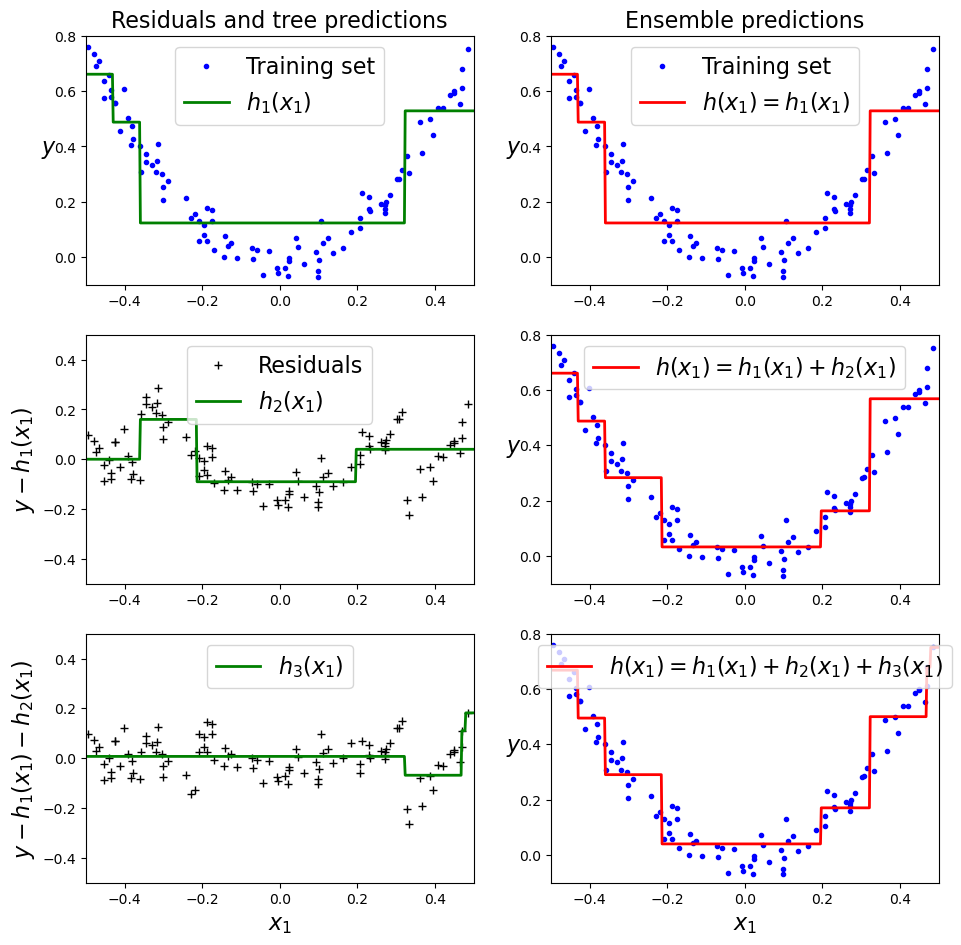

In [9]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

#save_fig("gradient_boosting_plot")
plt.show()

Now that you have solid understanding of Gradient Boosting in the regression scenario, let's apply the same algorithm to a classification problem. Specifically, the Titanic dataset and predicting survival.

**<font color='teal'>Use pandas read csv to load in the Titantic data set into a dataframe called df.</font>**

Hint: in this case you can use [dropna()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html) to just throw away any incomplete rows. For the purpose of this exercise we will disregard them but obviously in the real world you need to be much more careful and decide how to handle incomplete observations. 

In [10]:
# Upload titanic dataset
df = pd.read_csv("titanic.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


**<font color='teal'>Print the levels of the categorical data using 'select_dtypes'. </font>**

In [11]:
# Select columns from the DataFrame df that have data type 'object' (commonly used for strings or categorical variables)
# Exclude columns with data type 'datetime'
dfo = df.select_dtypes(include="object")
#
# Get the dimenshions of the df (rows, columns)
dfo.shape
#
# Get levels for all variables
# calculate the number of unique levels (unique values) for each column in the DataFrame df
vn = pd.DataFrame(dfo.nunique()).reset_index()
#
# reset_index() function is called to reset the index of the DataFrame
# assigning a new sequential index to each row. 
# The resulting DataFrame vn has two columns: 
# 'VarName' (containing the column names of dfo) 
# and 'LevelsCount' (containing the count of unique values for each column).
vn.columns = ["VarName", "LevelsCount"]
vn.sort_values(by="LevelsCount", ascending =False)
vn

,VarName,LevelsCount
0,Name,891
1,Sex,2
2,Ticket,681
3,Cabin,147
4,Embarked,3


**<font color='teal'>Create dummy features for the categorical features and add those to the 'df' dataframe. Make sure to also remove the original categorical columns from the dataframe.</font>**

In [12]:
# Drop the columns specified in dfo.columns from the DataFrame df
# Merge the newly created DataFrame with the result of one-hot encoding categorical columns from dfo DataFrame.
# The result is a merged DataFrame that combines the dropped columns from df and the one-hot encoded categorical columns from dfo.
# .drop(['PassengerId'], axis=1); drops the 'PassengerId' column from the merged DataFrame
df = pd.DataFrame(df.drop(dfo.columns,axis =1)).merge(pd.get_dummies(dfo.drop(['Name','Cabin','Ticket'],axis =1)),left_index=True,right_index=True).drop(['PassengerId'],axis =1)
print(df.shape)
df.head()

(891, 11)


,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,1,38.0,1,0,71.2833,1,0,1,0,0
2,1,3,26.0,0,0,7.9250,1,0,0,0,1
3,1,1,35.0,1,0,53.1000,1,0,0,0,1
4,0,3,35.0,0,0,8.0500,0,1,0,0,1


**<font color='teal'>Print the null values for each column in the dataframe.</font>**

In [13]:
# Calculate the number of missing values in each column
missing_values = df.isnull().sum()
#
# Sort the missing values in ascending order
missing_values_sorted = missing_values.sort_values(ascending=False)
#
print(missing_values_sorted)

Age           177
Survived        0
Pclass          0
SibSp           0
Parch           0
Fare            0
Sex_female      0
Sex_male        0
Embarked_C      0
Embarked_Q      0
Embarked_S      0
dtype: int64


In [14]:
# Handle null values in Age colum
df["Age"].fillna(df["Age"].mean(), inplace=True)

In [15]:
# Again check null values in each column
df.isnull().sum()

Survived      0
Pclass        0
Age           0
SibSp         0
Parch         0
Fare          0
Sex_female    0
Sex_male      0
Embarked_C    0
Embarked_Q    0
Embarked_S    0
dtype: int64

**<font color='teal'>Create the X and y matrices from the dataframe, where y = df.Survived </font>**

In [16]:
#  Separate the target variable Survive from the features
X = df.drop("Survived", axis=1)
y =df["Survived"]
X.shape, y.shape

((891, 10), (891,))

**<font color='teal'>Apply the standard scaler to the X matrix.</font>**

In [17]:
# Create instance class of the StandardScaler class
# .fit the StandardScaler() to input data X
# The step calculates the mean and std for each feature in X, 
# which will be used to transform the data later
scaler = preprocessing.StandardScaler().fit(X)
#
# Apply tranformation to the input data X using the StandardScaler instance
X_scaled = scaler.transform(X)

**scaler.transform(X)** applies the transformation to the input data X. It subtracts the mean and divides by the standard deviation for each feature in X, **_ensuring that each feature is centered around 0 and has a standard deviation of 1._**

**<font color='teal'>Split the X_scaled and y into 75/25 training and testing data subsets..</font>**

In [18]:
from sklearn.model_selection import train_test_split
#
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=42)
#
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((668, 10), (223, 10), (668,), (223,))

**<font color='teal'>Run the cell below to test multiple learning rates in your gradient boosting classifier.</font>**

In [19]:
learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
for learning_rate in learning_rates:
    gb = GradientBoostingClassifier(n_estimators=20, learning_rate = learning_rate, max_features=2, max_depth = 2, random_state = 0)
    gb.fit(X_train, y_train)
    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(gb.score(X_test, y_test)))

Learning rate:  0.05
Accuracy score (training): 0.798
Accuracy score (validation): 0.789
Learning rate:  0.1
Accuracy score (training): 0.822
Accuracy score (validation): 0.803
Learning rate:  0.25
Accuracy score (training): 0.832
Accuracy score (validation): 0.798
Learning rate:  0.5
Accuracy score (training): 0.850
Accuracy score (validation): 0.794
Learning rate:  0.75
Accuracy score (training): 0.853
Accuracy score (validation): 0.807
Learning rate:  1
Accuracy score (training): 0.853
Accuracy score (validation): 0.812


**<font color='teal'>Apply the best learning rate to the model fit and predict on the testing set. Print out the confusion matrix and the classification report to review the model performance.</font>**

In [20]:
# Learning rate 1 and 0.75 have the same training accuracy score
# Learning rate 1 will be used since validation score is higher
# Initialize a GradientBoostingClassifier and assing it gb1_Model
gb1_Model = GradientBoostingClassifier(n_estimators=20, learning_rate = 1, max_features=2, max_depth = 2, random_state = 0)
#
# Train gb1_Model on the training dataset
gb1_Model.fit(X_train, y_train)
#
# Predict on test
y_pred = gb1_Model.predict(X_test)
#
print("Accuracy score (validation) for Model 1: {0:.3f}".format(gb1_Model.score(X_test, y_test)))

Accuracy score (validation) for Model 1: 0.812


[[121  13]
 [ 29  60]]


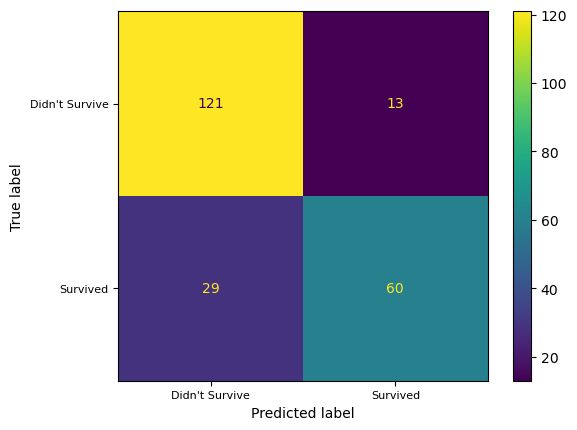

In [21]:
from sklearn.metrics import ConfusionMatrixDisplay
#Model performance
print(confusion_matrix(y_test, y_pred))
#
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Create a figure and axes
_, ax = plt.subplots()
#
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm, 
                                    display_labels = ["Didn't Survive", "Survived"])
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(labels = ["Didn't Survive", "Survived"], fontsize = 8)
ax.set_yticklabels(labels = ["Didn't Survive", "Survived"], fontsize = 8)
display_cm.plot(ax = ax)

In [22]:
# Print classification report to review the model performance
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.90      0.85       134
           1       0.82      0.67      0.74        89

    accuracy                           0.81       223
   macro avg       0.81      0.79      0.80       223
weighted avg       0.81      0.81      0.81       223



### Results Interpretation:
The results provided in the confusion matrix report various metrics for a binary classification problem. Let's interpret each of these metrics:

**1. Precision:**
   - Precision for class 0: 0.81
   - Precision for class 1: 0.82
   Precision represents the proportion of correctly predicted positive instances out of all instances predicted as positive. A precision of 0.81 for class 0 means that out of all instances predicted as class 0, 81% were actually correct. Similarly, a precision of 0.82 for class 1 means that out of all instances predicted as class 1, 82% were actually correct. It is calculated as TP / (TP + FP). In this case, the precision would be 60 / (60 + 13) ≈ 0.822 for the positive class.

**2. Recall (also known as sensitivity or true positive rate):**
   - Recall for class 0: 0.90
   - Recall for class 1: 0.67
   Recall represents the proportion of correctly predicted positive instances out of all actual positive instances. A recall of 0.90 for class 0 means that out of all actual instances of class 0, 90% were correctly predicted as class 0. Similarly, a recall of 0.67 for class 1 means that out of all actual instances of class 1, only 67% were correctly predicted as class 1.It is calculated as TP / (TP + FN). In this case, the recall would be 60 / (60 + 29) ≈ 0.674 for the positive class.

**3. F1-score:**
   - F1-score for class 0: 0.85
   - F1-score for class 1: 0.74
   The F1-score is the harmonic mean of precision and recall, providing a single metric that balances both. It takes into account both the precision and recall and provides a combined measure of the model's performance. An F1-score of 0.85 for class 0 means that the model achieves a good balance between precision and recall for class 0, while an F1-score of 0.74 for class 1 indicates a slightly lower balance between precision and recall for class 1. It is calculated as 2 * (precision * recall) / (precision + recall). In this case, the F1-score for the positive class would be 2 * (0.822 * 0.674) / (0.822 + 0.674) ≈ 0.741.

**4. Support:**
   - Support for class 0: 134
   - Support for class 1: 89
   Support represents the number of occurrences of each class in the actual target labels. In this case, there are 134 instances of class 0 and 89 instances of class 1 in the dataset.

**5. Accuracy: 0.81**
   Accuracy represents the overall correctness of the predictions made by the model. It is the proportion of correct predictions (both true positives and true negatives) out of all instances. In this case, the model achieves an accuracy of 81%.It is calculated as (TN + TP) / (TN + FP + FN + TP). In this case, the accuracy would be (121 + 60) / (121 + 13 + 29 + 60), which can be simplified to 181 / 223 ≈ 0.812.

**6. Macro Average:**
   - Macro average precision: 0.81
   - Macro average recall: 0.79
   - Macro average F1-score: 0.80
   The macro average takes the average of the precision, recall, and F1-score across all classes without considering class imbalance. In this case, the macro average precision is 0.81, the macro average recall is 0.79, and the macro average F1-score is 0.80.

**7. Weighted Average:**
   - Weighted average precision: 0.81
   - Weighted average recall: 0.81
   - Weighted average F1-score: 0.81
   The weighted average takes into account the support (number of instances) for each class and calculates the average weighted by the number of instances in each class. In this case, the weighted average precision, recall, and F1-score are all 0.81.


**<font color='teal'>Calculate the ROC for the model as well.</font>**

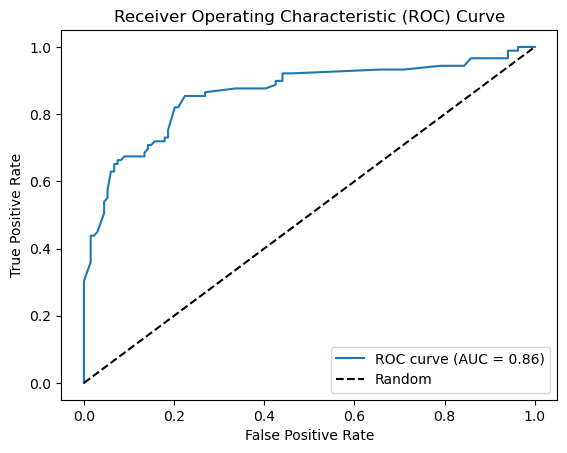

In [23]:
# Get the predicted probabilities for the positive class
y_pred_proba = gb1_Model.predict_proba(X_test)[:, 1]

# Calculate the false positive rate (FPR), true positive rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
#
# Calculate the Area Under the ROC Curve (AUC)
auc = roc_auc_score(y_test, y_pred_proba)
#
# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()